In [5]:
import numpy as np
import xarray as xr
from pathlib import Path
from scipy.interpolate import RectBivariateSpline

In [2]:
path = Path('/Users/jonniebarnsley/Downloads/ppe_dThickness_dt')
files = sorted(path.glob('*.nc'))

In [3]:
def open_file(file):
    ds = xr.open_dataset(file)
    last_time = ds.isel(time=-1)#['dThicknessdt']
    return last_time

In [4]:
ds_list = [open_file(f) for f in files]
ds = xr.concat(ds_list, dim='run')
ds = ds.assign_coords(run=range(len(ds.run)))

ValueError: must supply at least one object to concatenate

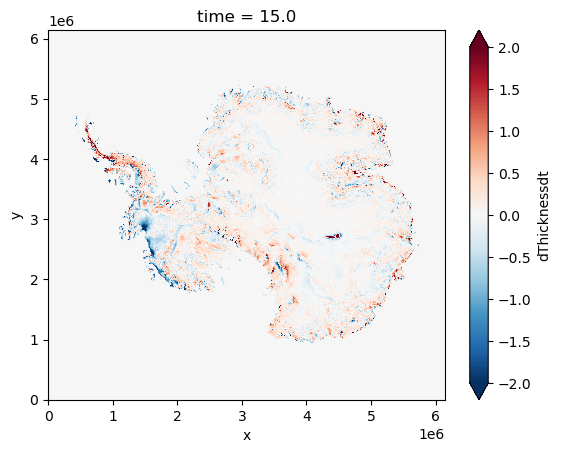

In [5]:
ds_mean = ds.mean(dim='run')
ds_mean['dThicknessdt'].plot(vmin=-2, vmax=2, cmap='RdBu_r')

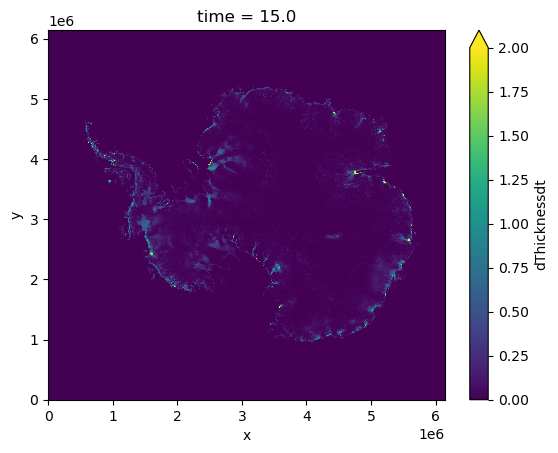

In [6]:
ds_std = ds.std(dim='run')
ds_std['dThicknessdt'].plot(vmax=2)

In [6]:
def read_raster(raster_path):
    """        
    Opens a tiff as specified by the user    
    Returns an array of the raster with co-oordinates
    """
    from osgeo import gdal, gdalconst  
    import numpy as np
    
    driver = gdal.GetDriverByName('Gtiff')
    driver.Register()
    src = gdal.Open(raster_path, gdalconst.GA_ReadOnly)
    ulx, xres, xskew, uly, yskew, yres  = src.GetGeoTransform()
    lrx = ulx + (src.RasterXSize * xres)
    lry = uly + (src.RasterYSize * yres)

    
    data=src.ReadAsArray()
    print("Opened %s" %(raster_path))
    #print(src.GetMetadata())
    
    tol = 1.0e-6
    x = np.arange(ulx,lrx-tol, +xres)
    y = np.arange(lry,uly-tol, -yres)
    
    return x, y, np.flipud(data[:,:])*365 # m/day -> m/a

In [7]:
xr, yr, dhdtr = read_raster('/Users/jonniebarnsley/Downloads/ICESat1_ICESat2_mass_change_updated_2_2021/dhdt/ais_dhdt_grounded_filt.tif')
xr -= (-3067750 - 4000)
yr -= (-3067750 - 4000)
dhdtr = np.where(np.isnan(dhdtr), 0.0, dhdtr)/365.0
dhdt = RectBivariateSpline(yr, xr, dhdtr)(ds_mean.y, ds_mean.x)

Opened /Users/jonniebarnsley/Downloads/ICESat1_ICESat2_mass_change_updated_2_2021/dhdt/ais_dhdt_grounded_filt.tif


/Users/jonniebarnsley/opt/anaconda3/envs/gdalenv/lib/python3.11/site-packages/osgeo/gdal.py:330: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


NameError: name 'ds_mean' is not defined

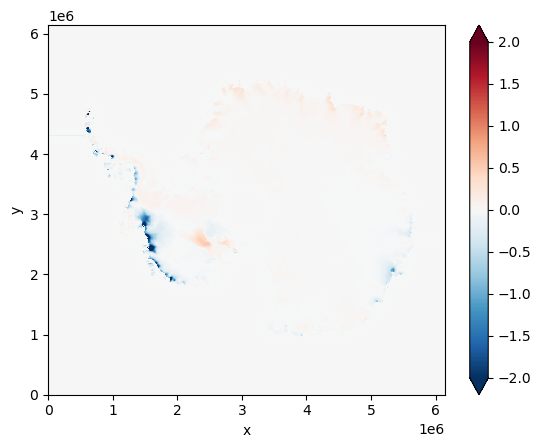

In [16]:
da = xr.DataArray(
    dhdt,
    coords={
        'x': ds_mean.x,
        'y': ds_mean.y
    },
    dims=['y', 'x']
)
da.plot(vmin=-2, vmax=2, cmap='RdBu_r')

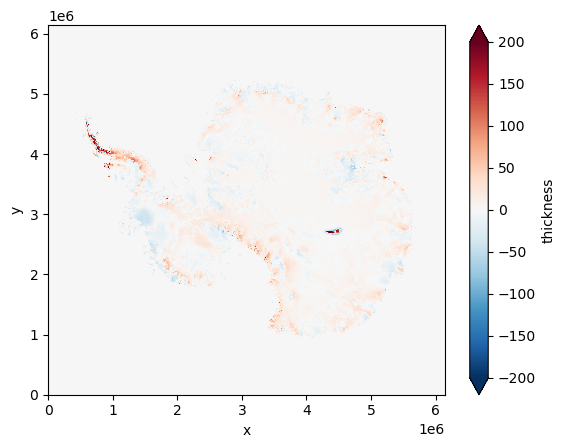

In [24]:
run001 = xr.open_dataset('/Users/jonniebarnsley/Downloads/control_run001/control_run001_thickness_0lev.nc')
thk = run001.thickness
dthk = thk.isel(time=-1) - thk.isel(time=0)
dthk.plot(cmap='RdBu_r', vmin=-200, vmax=200)

In [21]:
ds_mean.mean(dim=['x', 'y'])

<xarray.Dataset> Size: 16B
Dimensions:       ()
Coordinates:
    time          float64 8B 15.0
Data variables:
    dThicknessdt  float64 8B 0.003453

In [19]:
da.mean(dim=['x', 'y'])

<xarray.DataArray ()> Size: 8B
array(-0.00306668)